# Introduction

In this notebook, I present the research and development of a multi-label neural network model for object detection(not localization, just present or not present). Specifically, the targeted devices for deployment are microcontrollers, so the model must be constrained.

My intention is to train a small model to detect whether a person, a car, or both are present in an image. Note that **the following scripts can be used for different categories and applications**. Please check the rest of the repository to learn more and see the deployment phase to different microcontrollers.



# Setup

First let's import all the libraries we will need and set some configuration parameters.

In [4]:
#Common imports
import numpy as np
import time, os, sys, random
import pathlib
import urllib.request
import shutil, zipfile, tarfile
import pickle
from collections import defaultdict

# Tables
import pandas as pd

#Deep learning
import tensorflow as tf
import tensorflow_addons as tfa # F1 metric
from tensorflow import keras
assert tf.__version__ >= "2.0"

#Reproducibility
random.seed(23)
np.random.seed(23)
tf.random.set_seed(23)

#Plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#Dataset utilities
from pycocotools.coco import COCO

As you can see in the last import, we will use the `pycocotools` library to build our data pipeline.

For reproducibility, here is some info of what I have installed:

In [5]:
# Record package versions for reproducibility
print("OS: {}".format(os.name))
print("Python version: {}".format(sys.version))
print("Numpy: {}".format(np.__version__))
print("Tensorflow: {}".format(tf.__version__))

OS: nt
Python version: 3.8.5 | packaged by conda-forge | (default, Aug 29 2020, 00:43:28) [MSC v.1916 64 bit (AMD64)]
Numpy: 1.19.1
Tensorflow: 2.3.0


Finally let's set up a couple of global variables

In [6]:
ROOT_PATH = "."
DATA_DIR = os.path.join(ROOT_PATH, "data")
coco_year = 2017

# Get the data

### Considerations

Unfortunately, the ImageNet dataset does not contain a class "person", so instead we can use the [COCO dataset](https://cocodataset.org/#home). On top of having the person class, the dataset name means "Common Objects in COntext" so, in theory, the images will be a better representation of the reality the model will be exposed to in the final application.

The visual wake word dataset would have been useful for this application if it could be extended to more than one foreground class, but it served as inspiration.

(TODO) Finally, as we will see, retraining the final model(fine tuning) with captured images from the environment and device the model will be deployed on will help improve its performance.

### Why COCO?
The application proposed in the repository talks about detecting pedestrians and vehicles in crossroads, so using a more specialized dataset should be the right choice. On the other hand, this is meant to be a demo to test at home or show to your employer or stakeholders before proceeding with the final application. Therefore, the COCO dataset is a great choice due to its context rich images. It should be as easy as feeding the model a different dataset during the transfer learning phase to apply it to a similar task. At most, tuning some hyperparameters for fine-tuning.

### Execution
The COCO dataset is designed for a variety of deep learning applications, but classification is not one of them, so we will need to play with the COCO API to get the data in the format we want for **multi-label** classification.

The following class provides an easy interface to do just that, from downloading the original annotations and images, to the conversion to a `tf.dataset` or `torch.utils.data.DataLoader` object for an optimized data pipeline. The information and comments provided should be enough to understand its API, but do not forget to check the rest of the repository for the standalone script and more usage information.

In [7]:
class COCO_MLC():
    """
    COCO_C aims to convert the original COCO dataset into a classification problem. This approach
    makes the task easier and smaller models can be fit. Useful for constrained devices.
    
    Args:
        data_dir: Folder where all data will be downloaded
        year: COCO dataset year
    
    """
    def __init__(self, data_dir, year="2017"):
        self.data_dir = data_dir
        self.year = str(year)
        self.ANN_FOLDER = os.path.join(self.data_dir, "annotations")
        self.split_names = ["instances_train{}.json".format(self.year),
                            "instances_val{}.json".format(self.year)]
        self.coco_categories = []
        self.coco_objs = dict()
        self.datasets = []
        self.datasets_lens = []
        self.classes = []
        
        if not os.path.exists(self.data_dir):
            print("data_dir does not exist, creating directory now")
            os.makedirs(self.data_dir)
            
    def download_annotations(self, delete_zip=False):
        """
        Create annotations folder in data dir and download `year` COCO annotations.

        """
        ANN_ZIP_FILE_PATH = os.path.join(self.ANN_FOLDER, "annotations_train{}.zip".format(self.year))
        ANN_URL = r"http://images.cocodataset.org/annotations/annotations_trainval{}.zip".format(self.year)
        
        if not os.path.exists(self.ANN_FOLDER):
            print("Creating annotations folder: {}".format(self.ANN_FOLDER))
            os.makedirs(self.ANN_FOLDER)
        if not os.path.exists(ANN_ZIP_FILE_PATH):
            print("Downloading annotations...")
            with urllib.request.urlopen(ANN_URL) as resp, open(ANN_ZIP_FILE_PATH, 'wb') as out:
                shutil.copyfileobj(resp, out)
            print ("... done downloading.")
        
        print("Unzipping {}".format(ANN_ZIP_FILE_PATH))
        with zipfile.ZipFile(ANN_ZIP_FILE_PATH,"r") as zip_ref:
            for split in self.split_names:
                split_zip_path = os.path.join("annotations", split)
                split_zip_path = split_zip_path.replace("\\", "/") # Needed by zipfile
                zip_ref.extract(split_zip_path, self.data_dir)
        print ("... done unzipping")

        if delete_zip:
            print("Removing original zip file...")
            os.remove(ANN_ZIP_FILE_PATH)
        print("... done")
        
        # Let's create a list of categories for the user to check
        val_ann_file = os.path.join(self.ANN_FOLDER, self.split_names[1])
        coco_obj = COCO(val_ann_file)
        cats = coco_obj.loadCats(coco_obj.getCatIds())
        self.coco_categories = [cat['name'] for cat in cats]
        
        print("Download annotations done")
        
    def download_images(self, classes=[], threshold_areas=[], only_length=False, max_length=None,
                       add_negative_class=True, neg_classes=[]):
        """
        Download images from the desired classes and store them in different folders. For example, 
        after running `download_annotations` and then this function with "person" and "car" classes,
        we end up with a tree that looks as follows:

        -- data_dir
            |-- annotations
            |-- train
            |   |-- car
            |   `-- person
            `-- val
                |-- car
                `-- person

        
        Args:
            classes: classes from which to download images
            threshold_areas: mininum area percentage the desired foreground object
                            must have to be downloaded. A threshold must be provided for each
                            class
            only_length: when True, it does not download the images
            max_length: the max number of COCO annotations to scan for. By default scans all.
                        This is useful when you want to get only a few downloaded images when 
                        trying new 'threshold_area' values. Note that in COCO dataset there is 
                        usually more than one annotation per image, so this parameter is not 
                        the amount of images to be downloaded, although the more annotations 
                        you scan, the more images will be downloaded, allsatisfying the 
                        `threshold_area` constraint.
            add_negative_class: when True, it downloads images that do not correspond to any 
                        of the `classes`. It downloads as many as needed to have a balanced 
                        dataset.
            neg_classes: COCO categories that will end up in the negative class. If empty,
                        it will use all remaining categories not in `classes`. It will
                        contain equal amount of each negative class(balanced).
        
        Returns:
            A dictionary with keys "train" and "val" that contains per split per
            category data length
        
        """
        if not classes:
            return
        self.classes = classes
        split_dirs = ["train", "val"]
        data_lens = {"train":[], "val":[]}
        
        for split, split_dir in zip(self.split_names, split_dirs):
            split_path = os.path.join(self.ANN_FOLDER, split)
            coco = COCO(split_path) # Should we make these class attributes? What about memory?
            self.coco_objs[split_dir]=coco
            cat_ids = coco.getCatIds(self.classes)
            for cat_id, cat_name, threshold_area in zip(cat_ids, self.classes, threshold_areas):
                print("Downloading {} data for {} category".format(split_dir, cat_name))
                cat_path = os.path.join(self.data_dir, split_dir ,cat_name)
                os.makedirs(cat_path, exist_ok=True)
                
                # load annotations
                ann_ids = coco.getAnnIds(catIds=[cat_id])[:max_length]
                anns = coco.loadAnns(ann_ids)
                
                # Check area threshold and create img data list
                imgs_data=[]
                for ann in anns:
                    img_id = ann["image_id"]
                    img = coco.loadImgs([img_id])[0]
                    img_area = img["height"] * img["width"]
                    normalized_object_area = ann["area"]/img_area
                    if normalized_object_area > threshold_area:
                        if img not in imgs_data: # Same image can have several annotations
                            imgs_data.append(img)
                
                N = len(imgs_data)
                data_lens[split_dir].append(N)
                if only_length:
                    continue
                    
                # Download images
                tic = time.time()
                for i, img in enumerate(imgs_data):
                    fname = os.path.join(cat_path, img['file_name'])
                    if not os.path.exists(fname):
                        urllib.request.urlretrieve(img['coco_url'], fname)
                    print('Downloaded {}/{} images (t={:.2f}s)'.format(i+1, N, time.time()- tic), end="\r")
                print("\n")
                
            if add_negative_class:
                print("Downloading {} data for negative category".format(split_dir, cat_name))
                neg_path = os.path.join(self.data_dir, split_dir, "negative")
                os.makedirs(neg_path, exist_ok=True)
                
                # Obtain the number of images per class to get a balanced negative class
                if not neg_classes:
                    # all categories except the positive ones
                    all_cats = coco.loadCats(coco.getCatIds())
                    neg_classes = set([cat["name"] for cat in all_cats]) - set(self.classes)   
                    
                #neg_len = np.array(data_lens[split_dir], dtype=np.int64).mean(dtype=np.int64)
                neg_len = max(data_lens[split_dir])
                imgs_per_class = max(1, neg_len / len(neg_classes))
                
                # The COCO API has an attribute of type dictionary where each category_id key maps to
                # all images_ids of that class. Let's use that to make sets.
                
                # Get the positive image ids, we use sets to avoid duplicates.
                pos_classes_img_ids = set()
                for cat_id in cat_ids:
                    pos_classes_img_ids |= set(coco.catToImgs[cat_id])
                
                neg_classes_id = coco.getCatIds(neg_classes)
                
                # Find non negative images that do not contain positives and add `imgs_per_class` from
                # each subclass to the negative one.
                neg_images_ids = []
                for nclass_id in neg_classes_id: # TODO(Look for a better way)
                    n_subclass_imgs = set(coco.catToImgs[nclass_id])
                    n_subclass_imgs -= pos_classes_img_ids
                    imgs_to_sample = imgs_per_class if len(n_subclass_imgs)>imgs_per_class \
                                    else len(n_subclass_imgs)
                    n_subclass_imgs = random.sample(tuple(n_subclass_imgs), int(imgs_to_sample))
                    neg_images_ids.extend(n_subclass_imgs)
                
                neg_imgs_data = coco.loadImgs(neg_images_ids)
                N = len(neg_imgs_data)
                data_lens[split_dir].append(N)
                if only_length:
                    continue
                
                # Download negative images
                tic = time.time()
                for i, img in enumerate(neg_imgs_data):
                    fname = os.path.join(neg_path, img['file_name'])
                    if not os.path.exists(fname):
                        urllib.request.urlretrieve(img['coco_url'], fname)
                    print('Downloaded {}/{} images (t={:.2f}s)'.format(i+1, N, time.time()- tic), end="\r")
                print("\n")
        if add_negative_class:
            self.classes.append("negative")
        return data_lens
    
    
    def to_tf_dataset(self, img_size=(240, 320), channels=3, batch_size = 32, normalize=False, \
                      max_class_len=[]):
        """
        Get `tf.data.Dataset` object from all the images downloaded in a convenient format for
        the train and validation splits.
        
        Args:
            img_size: this is the size (heigh, width) the images will be resized to
            channels: indicates the desired number of color channels for the output images. 
                      Accepted values are: 0 for automatic, 1 for grayscale, 3 for RGB.
            batch_size: the number of examples per batch
            normalize: whether to normalize the images to the [-1,1] range
            max_class_len: If specified, limit the per class examples(chosen randomly) to a fixed number. 
                      Must be a list of two elements(train and validation max class lengths). If None, 
                      there is no limit.
            
        Returns:
            train_ds: tf.data.Dataset for the train split where each element is a tuple; the first
                      element is the images with shape(batch_size, img_height, img_width, channels)
                      and the second is the labels with shape (batch_size, num_classes). Each label
                      is a vector with ones on the category indexes the image corresponds to and
                      zero otherwise.
            val_ds: tf.data.Dataset for the validation split that shares the same format as `train_ds`
            class_names: array containing the class names, with its indexes matching the datasets
                      labels.
            datasets_lens: list containing the train and val dataset lengths(number of examples), in 
                      that order.
        """
        # If you know how to improve this function please let me know or make a pull request
        # For convenience, lets use pathlib
        data_dir = pathlib.Path(self.data_dir)
        #class_names = np.array(self.classes) # Alternative
        class_names = np.array(sorted([item.name for item in data_dir.glob('train/*')])) 
        
        #Let's define a couple of inner functions we will use later
        def to_img_name(s):
            # This is used to go from a full path like data/train/person/001.jpg
            # to just 001.jpg
            return str(s).split(os.path.sep)[-1]
        
        def process_path(file_path, img_width, img_height):
            # A function to load an image from a path
            img = tf.io.read_file(file_path)
            img = tf.image.decode_jpeg(img, channels=channels)
            img = tf.image.resize(img, [img_height, img_width])
            return tf.cast(img, dtype=tf.uint8)
        
        def configure_for_performance(ds, img_batch_size):
            # Configure a tf.data.Dataset for performance
            #ds = ds.cache() # This fills up too much memory, prefetch should be fine
            #ds = ds.shuffle(shuffle_buf_size) # already done before
            ds = ds.batch(img_batch_size)
            ds = ds.prefetch(buffer_size=AUTOTUNE)
            return ds
        
        AUTOTUNE = tf.data.experimental.AUTOTUNE
        split_dirs = ["train", "val"]
        datasets = [] # this is where the tf datasets will be stored
        self.datasets_lens = []
        for split_ix, split in enumerate(split_dirs):
            img_filen = [] # tuple list where each pair is (image_filename, class_index)
            for i, class_n in enumerate(class_names):
                # For each class, get a list of all images in the corresponding folder and
                # make a tuple with its class index.
                pattern = "{}/{}/*.jpg".format(split, class_n)
                class_filen = [(filen, i) for filen in map(to_img_name, data_dir.glob(pattern))]
                if max_class_len:
                    # To avoid bias, we shuffle the filenames before slicing
                    random.shuffle(class_filen)
                    class_filen = class_filen[:max_class_len[split_ix]]
                img_filen += class_filen
                # for example, an element would now look like ('000000003711.jpg', 0)
            
            # Now we have to merge duplicate image files with different labels. To do so, we can
            # use a dictionary where each image filename is a key and the values are a list of
            # class indexes
            merged_dict = defaultdict(list)
            for filen, label in img_filen:
                merged_dict[filen].append(label)
            #Lets convert it back to a list
            img_filen = list(merged_dict.items())
            # an element with more than one class would now look like ('000000005205.jpg', [0, 2])
            self.datasets_lens.append(len(img_filen))
            
            # Now we need to reconstruct the full image filepath(to one of them) and encode the
            # labels as "multi-label one hot"
            for ix, elem in enumerate(img_filen):
                filen, labels = elem
                # Images with multiple labels have multiple possible filepaths(i.e. 
                # they exist in different categories) so we will take the first one,
                # for example.        
                class_n = class_names[labels[0]]
                full_path = data_dir / split / class_n / filen
                
                # The label has 1s wherever the index class corresponds to the example
                label = np.zeros(len(class_names),)
                label[labels] = 1
                
                img_filen[ix] = [str(full_path), label]
            # an element with more than one class would now look like
            # ()'data\\train\\car\\000000003711.jpg', array([1., 0., 0.]))            
            # Let's start creating the filename dataset
            filenames, labels = zip(*img_filen)
            filenames, labels = list(filenames), np.array(labels, dtype=np.float32) # for tf.data
            dataset = tf.data.Dataset.from_tensor_slices( (filenames, labels) )
            # This is a good time to shuffle the dataset, before loading the images.
            # This allows us to shuffle with a buffer as big as len(filenames)
            dataset = dataset.shuffle(buffer_size = len(filenames))
            
            # Let's use process_path() to get the image dataset
            h, w = img_size
            dataset = dataset.map(lambda x, y: (process_path(x, w, h), y), \
                                  num_parallel_calls=AUTOTUNE)
            if normalize:
                normalize = lambda img : (tf.cast(img, tf.float32) / 127.5)-1
                dataset = dataset.map(lambda x, y: (normalize(x), y), \
                                  num_parallel_calls=AUTOTUNE)
            
            # Batch it and configure it for performance
            dataset = configure_for_performance(dataset, batch_size)
            
            datasets.append(dataset)
        
        self.datasets = datasets
        
        return (*self.datasets, class_names, self.datasets_lens)
    
    def to_torch_dataloader(self):
        print("This function is not yet implemented.")
        return


With that done, we can create a `COCO_MLC` instance and download the annotations of the original COCO dataset.

In [8]:
coco_mlc = COCO_MLC(DATA_DIR, coco_year)

In [203]:
coco_mlc.download_annotations(delete_zip=False)

Unzipping .\data\annotations\annotations_train2017.zip
... done unzipping
... done
loading annotations into memory...
Done (t=0.60s)
creating index...
index created!
Download annotations done


Now we can download images for the categories we want. In this case "person" and "car" are the classes of interest. We can also specify the percentage of area `threshold_areas` the object of interest must have in the image to get rid of the images where it is too small for each class. By default, it will also download a negative class; this is useful because there could be no people or cars in the image, so it is helpful for the model to have a class to specify that situation.

Exploring the COCO dataset on the official website, we can see that there are considerably more person images(66k) than car images(12k), so to help reduce that imbalance we set a lower threshold area for the car class.

In [226]:
classes = ["person", "car"]
threshold_areas = [0.05, 0.01]
class_lengths = coco_mlc.download_images(classes, threshold_areas=threshold_areas, \
                         add_negative_class=False) # negative class already downloaded

loading annotations into memory...
Done (t=21.84s)
creating index...
index created!
Downloaded 37585/37585 images (t=13.31s)

Downloaded 6263/6263 images (t=2.38s)

loading annotations into memory...
Done (t=0.71s)
creating index...
index created!
Downloaded 1565/1565 images (t=0.55s)

Downloaded 254/254 images (t=0.08s)



Let's check how many images per split and per class we have:

In [227]:
class_lengths

{'train': [37585, 6263], 'val': [1565, 254]}

Each list corresponds to the number of images of person, car, and negative classes on each split, respectively. It is clear we have an imbalanced dataset. There are several approaches to this problem, some of them are:

- Get more data, which if it were a commercial application should be seriously considered.
- Oversampling, making copies of the under-represented class images.
- Undersampling, deleting instances from the over-represented class.
- _Generate_ synthetic data, using algorithms like SMOTE or even a GAN.
- Setting class weights, although training may produce abrupt steps.

Iterating over this step, I have realised the car class is not really well represented in the dataset, as reflected in the precision and recall of that class, so we need to get more data first. If you browse the car folder, you will quickly see how some images have blurred or occluded cars; and that is not entirely bad to make the model more sensitive, but more samples with a car in the foreground will help improve performance and meet our end application goals. Although it doesn't have the context variety of the COCO dataset, the [Cars dataset](https://ai.stanford.edu/~jkrause/cars/car_dataset.html) should work just fine.

After that, since we will use transfer learning techniques we will stick to the undersampling option, limiting the number of examples for training to `6263+4000=10263` which is the minimum of examples for a class(car) plus the car images we will add from the Cars dataset. This means we will throw away a lot of precious data, but we can always come back and try an alternative if the application performace does not meet its goals, as we have just done. Nevertheless, with only three classes and a pre-trained model we should be all right now.

To get more data, we will download `4000` training samples and `500` validation samples. Let's write a function that will both download the images and copy them the respective folders `data_dir/train/car` and `data_dir/val/car`:

In [9]:
def download_and_merge_car_dataset(data_dir, n_train, n_val, car_filenames_pkl=None):
    """
    Download the cars dataset (https://ai.stanford.edu/~jkrause/cars/car_dataset.html) and copy `n_train`
    examples to data_dir/train/car and `n_val` examples to data_dir/val/car. The data downloaded is only the
    train split from the cars dataset, which has 8144 examples. Therefore, `n_train + n_val` should not exceed
    that quantity to prevent overlapping.

    Args:
        data_dir: data folder path
        n_train: number of train examples to copy to the destination folder data_dir/train/car
        n_val: number of val examples to copy to the destination folder data_dir/val/car
        car_filenames_pkl: To ensure future calls don't copy different images to the destination folders, a
            list of filenames is stored in `data_dir` if None. If specified, the filenames list is loaded.
            The first call should create such list. Subsequent calls should load from disk. This is needed
            because the filenames are shuffled before copying.

    """
    dataset_path = os.path.join(data_dir, "cars_dataset")
    if not os.path.exists(dataset_path):
        print("Creating cars_dataset folder")
        os.makedirs(dataset_path)
    
    zip_filepath = os.path.join(dataset_path, "cars_train.tgz")
    zip_url = "http://imagenet.stanford.edu/internal/car196/cars_train.tgz"
    if not os.path.exists(zip_filepath):
        print("Downloading dataset...")
        with urllib.request.urlopen(zip_url) as resp, open(zip_filepath, 'wb') as out:
            shutil.copyfileobj(resp, out)
        print ("... done downloading.")

    print("Unzipping {}".format(zip_filepath))
    #with tarfile.open(zip_filepath, "r") as fc:
    #    fc.extractall(dataset_path)
    
    if car_filenames_pkl:
        print("Reading from existing filenames")
        with open(car_filenames_pkl, 'rb') as cf:
            car_filenames = pickle.load(cf)
    else:
        print("Creating car_filenames.pkl for reproducible future calls")
        dataset_path = pathlib.Path(dataset_path)
        print(dataset_path)
        car_filenames_gen = dataset_path.glob("cars_train/*")
        car_filenames = [str(fn).split(os.path.sep)[-1] for fn in car_filenames_gen]
        random.seed(23)
        random.shuffle(car_filenames)
        with open("car_filenames.pkl", "wb") as cf:
            pickle.dump(car_filenames, cf)

    cars_train = car_filenames[:n_train]
    cars_val = car_filenames[-n_val:]

    print("Copying {} train examples".format(n_train))
    for fn in cars_train:
        src = "{}/cars_dataset/cars_train/{}".format(data_dir, fn)
        dst = "{}/train/car/{}".format(data_dir, fn)
        shutil.copyfile(src, dst)
    
    print("Copying {} validation examples".format(n_val))
    for fn in cars_val:
        src = "{}/cars_dataset/cars_train/{}".format(data_dir, fn)
        dst = "{}/val/car/{}".format(data_dir, fn)
        shutil.copyfile(src, dst)

    print("Done")

In [247]:
download_and_merge_car_dataset(DATA_DIR, n_train=4000, n_val=500, car_filenames_pkl=None)

Unzipping .\data\cars_dataset\cars_train.tgz
Creating car_filenames.pkl for reproducible future calls
data\cars_dataset
Copying 4000 train examples
Copying 500 validation examples
Done


With that done, since we are using tensorflow and keras, we create the `tf.data.Dataset`s for the train and validation splits. We want the images to be normalized in the range `[-1,1]` and since the main target for the application features a relatively powerful ARM Cortex-M7 processor we will leave the image channels to `3`(RGB). The image size was decided after model selection. Finally, as described just above, we can use the `max_class_len` parameter to limit the number of examples per class. For validation we will not apply that limit though(setting it to `None`), we will just have to choose wisely the metrics for model evaluation.

Note that this function scans for files the folder structure `COCO_MLC.download_images` created, and that's why it will also take into account the Cars dataset's images we have just added.

In [10]:
max_examples = 10263
BATCH_SIZE = 32
IMG_SIZE = (224,224)

In [11]:
dataset_params = dict(
    img_size = IMG_SIZE,
    channels = 3,
    normalize = True,
    batch_size = BATCH_SIZE,
    max_class_len = [max_examples, None]
)

train_ds, val_ds, class_names, datasets_lens = coco_mlc.to_tf_dataset(**dataset_params)

# Explore the data

Let's take a moment to actually see the data we are working with. The number of examples per class and split is

In [13]:
def get_exs_per_class(dataset):
    class_counts = np.array([0, 0 , 0])
    for image_batch, label_batch in iter(dataset):
        for i in range(len(label_batch)):
            label = label_batch[i]
            label_ixs = tf.where(label).numpy()
            class_counts[label_ixs] += 1
    return class_counts
    
print("Train examples per class:  {}".format(get_exs_per_class(train_ds)))
print("Val examples per class:  {}".format(get_exs_per_class(val_ds)))

Train examples per class:  [10263 10263 10263]
Val examples per class:  [ 754 1018 1565]


The classes with the correct index are

In [14]:
print(class_names)

['car' 'negative' 'person']


Great! Now let's see some images

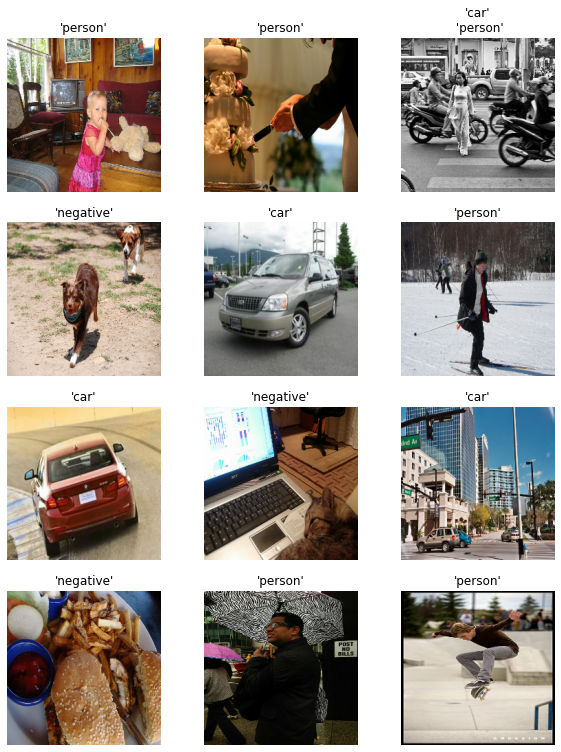

In [26]:
image_batch, label_batch = next(iter(val_ds))

plt.figure(figsize=(10, 13))
for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    img = ((image_batch[i].numpy()+1)*127.5).astype("uint8") # channels = 3
    plt.imshow(img) # channels = 3
    #img = (tf.squeeze(image_batch[i]).numpy()) # channels = 1
    #plt.imshow(img, cmap='gray') # channels = 1
    label = label_batch[i]
    label_ixs = tf.where(label).numpy()
    plt.title(str(class_names[label_ixs]).replace("[", "").replace("]",""))
    plt.axis("off")
plt.show()

As we can see, some images have multiple classes, and some just correspond to the negative one. Let's proceed to the model selection step.

# The model

While doing some research, I came across [these amazing tables](https://github.com/nerox8664/awesome-computer-vision-models) containing lists of computer vision models for different tasks, with some characteristics like performance or number of parameters. I exported the classification model table and filtered them with the following criteria:
- A microcontroller has limited flash and RAM memory, so a model with a low number of parameters is needed.
- They also have a limited clockspeed, so the number of floating point operations(FLOPS) should not be too high.
- Since we will be doing transfer learning, a pre-trained model should be available.

These are the top five models meeting those filters and sorted by top one error rate:

In [27]:
best_small_models = pd.read_csv("parsed_classification_models.csv")[:5] # utils.ipynb has the filtering code
best_small_models.iloc[:5,1:]

,Model,Number of parameters,FLOPS (millions),Top-1 Error,Top-5 Error,Year
0,EfficientNet-B0,"5,288,548",414.31,24.77,7.52,2019
1,NASNet-A 4@1056,"5,289,978",584.90,25.68,8.16,2017
2,MobileNet,"4,231,976",579.80,26.61,8.95,2017
3,MobileNetV2,"3,504,960",329.36,26.97,8.87,2018
4,ShuffleNetV2,"2,278,604",149.72,31.44,11.63,2018


The main target for this application is an STM32H7 microcontroller, with generous 2MB of flash memory and 1MB of RAM. Those are really high-end specifications for a microcontroller. Still, none of the models in that list would fit those constraints, at least not in their original form. Both [EfficentNet](https://arxiv.org/abs/1905.11946) and [NASNet](https://arxiv.org/abs/1707.07012) shine on mobile applications, but [MobileNet](https://arxiv.org/abs/1704.04861) and [MobileNetV2](https://arxiv.org/abs/1801.04381) apart from performing nearly as well, they propose two hyperparameters that affect the model complexity and capacity and, in turn, size and latency.

### MobileNets
The MobileNet architecture was first proposed by Google in 2017 and showed how small and quick models could achieve near state of the art performance. The main idea is the use of depthwise separable convolution layers instead of the standard ones: First, a filter is applied to **one and each** input channel(i.e. spatially). Then, a 1x1 filter is applied to all of the resulting feature maps across the channels(i.e. depthwise). For a more visual and rigorous explanation please refer to the paper or to the repository.

It can be shown that the computational cost ratio between depthwise separable convolution and standard convolution is:

$$ r = \frac{1}{N} + \frac{1}{D^{2}_{k}} $$

Where $N$ is the number of output channels and $D_k$ is the kernel(filter) height and width. With $N$ being typically in the range of [32, 1024] and the kernel sizes for depthwise separable convolutions being always $3\times3$, they need 7 o 9 times less computations than standard convolutions. Of course, another way of reducing the computational cost would be feeding a smaller image to the input, which is also shown in the paper.

As for the model size, while MobileNet already has relatively few parameters(around four million) we can push them a lot further down with a "width multiplier": For a given layer and width multiplier $\alpha$, the number of input channels $M$ becomes $\alpha M$ and the number of output channels $N$ becomes $\alpha N$. It can also be shown that the computational cost and number of parameters is reduced by _roughly_ a factor of $\alpha^2$.

MobileNetV2 was proposed in 2019 and iterates over its antecessor adding new concepts like inverted residuals or linear bottlenecks, improving the performance on popular datasets and keeping and __even smaller footprint__.

### Baseline model

The good thing is that Keras has pre-trained MobileNets(V1 and V2) with different `alpha`s, so we can use those pre-trained models and see which one fits our needs.

I've already gone ahead and trained a few baseline models with "out of the box" hyperparameters with different MobileNet versions and depths to get an idea of the performance we will be getting. I manually wrote the results in a CSV file which we will be filling with the different architectures and hyperparameters we try. This is what I got:

In [28]:
model_selection = pd.read_csv("model_selection.csv")
model_selection

,Version,alpha,n_dense,loss,SizeFP16(MB),train_accuracy,val_accuracy,val_AUC,val_macrof1,val_precision,val_recall,OptTR,OptFT,lr_TR,lr_FN
0,V1,0.50,256,BCE,1.871,0.8407,0.8171,0.9422,-1,-1,-1,Adam,RMSProp,0.0001,0.00001
1,V2,0.50,256,BCE,2.031,0.8594,0.8298,0.9524,-1,-1,-1,Adam,RMSProp,0.0001,0.00001
2,V2,0.35,256,BCE,1.465,0.8436,0.8290,0.9494,-1,-1,-1,Adam,RMSProp,0.0001,0.00001


Loss `BCE` refers to binary cross-entropy. The optimizers and learning rates are different during transfer learning and fine tuning. The `n_dense` refers to the number of neurons in the fully connected layer after the base model. The training accuracy is quite decent given that the COCO dataset is quite diverse and some of the images have blurred or occluded elements(try browsing the data folder if you've downloaded it). For a more context specific scenario, like pedestrian and vehicle detection in crossroads, the model would definitely perform better if fed a good specific dataset. The validation accuracy(although person-class biased) is quite close to the training one, showing it hasn't overfit. We will be looking at different metrics for validation soon.

The model size though is clearly a problem: With `alpha` higher or equal than `0.5` the model is too close or surpasses the flash memory limit. Still, and this is what makes MobileNets really powerful, is that they scale down quite nicely; with `alpha=0.35` in MobileNetV2 and `n_dense=256` the model fits in less than 1.5MB, leaving 500 kilobytes for the application, which should be enough if it is not too complex. It is important to note that the size refers to the model _quantized_ to 16-bit floats, meaning that the original parameters have been shrunk from 32-bit floats to 16-bit ones. The precision loss is not really important during inference and it gives us a x2 size reduction, so it is definitely worth it. One could also quantize the model to 8-bit integers, although it is a little more complicated and we will leave it to another application since the microcontroller we use has an FPU(floating point unit).

### Loss and metrics

Before delving deeper into the model creation I would like to discuss the model's metrics and loss. For the metrics we will be sticking with accuracy and F1 score. If you are not familiar with the latter, it is just the harmonic mean of the _precission_ and _recall_:

$$F_{1}=\frac{2}{\operatorname{recall}^{-1}+\text {precision }^{-1}}$$

If we decompose those terms in terms of true positives, false positives and false negatives, the F1 score looks like this:  

$$F_1 = \frac{2\mathrm{tp}}{2\mathrm{tp} + \mathrm{fp}+\mathrm{fn}}$$

The harmonic mean is the equivalent of the arithmetic mean for reciprocals of quantities that should be averaged by the arithmetic mean. To give some intuition, think about how the reciprocals of both precision and recall share the same denominator(true positives), so when we sum those quantities we are actually getting the arithmetic mean of false positives and false negatives over true positives. Finally, we take the reciprocal of that sum to transform it to the original representation. Visually, we see that to keep a high $F_1$ score we need an equilibrium between precision and recall:

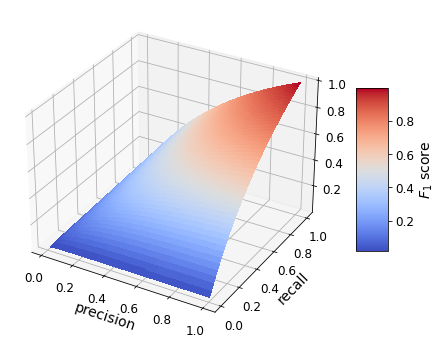

In [29]:
fig = plt.figure(figsize=(8,6))
ax = fig.gca(projection='3d')

precision = np.linspace(0.01, 1, 100)
recall = np.linspace(0.01,1,100)
pp, rr = np.meshgrid(precision, recall)
f1 = 2/((1/pp)+(1/rr))

surf =ax.plot_surface(pp, rr, f1, cmap=mpl.cm.coolwarm,
                linewidth=0, antialiased=False)

fig.colorbar(surf, shrink=0.5, aspect=5, label="$F_1$ score")
ax.set_xlabel("precision")
ax.set_ylabel("recall")
plt.show()

For the multi-label classification task we can just take the average of each class' $F_1$ score, which we will call "macro $F_1$ score". We will a threshold of `0.5` for this metric.

Going one step further, I found [this amazing post](https://towardsdatascience.com/the-unknown-benefits-of-using-a-soft-f1-loss-in-classification-systems-753902c0105d) explaining how one could even make a differentiable F1 function to use as loss. He also explains some of the benefits like optimizing directly for the macro $F_1$ score and the fact that the need for choosing a threshold to consider each class positive is implicitly inside the loss and we don't have to tweak those values. For more details and implementation details, I highly encourage you to check the post.

Nevertheless, although that sounds great we will also try the go-to loss function: binary cross-entropy, which maximizes the log likelihood for each class and then we will see which one performs better for our task.

We can use the `metrics.F1Score` metric inside tensorflow-addons, but we'll define our own custom loss:

In [30]:
class MacroDoubleSoftF1(keras.losses.Loss):
    """
    Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.
    This version uses the computation of soft-F1 for both positive and negative class for each label.
    Credits to ashrfem in github.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    def __init__(self, name="macro_double_soft_f1", **kwargs):
        super().__init__(name=name, **kwargs)
        
    def call(self, y_true, y_pred):
        y = tf.cast(y_true, tf.float32)
        y_hat = tf.cast(y_pred, tf.float32)
        
        tp = tf.reduce_sum(y_hat * y, axis=0)
        fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
        fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
        tn = tf.reduce_sum((1 - y_hat) * (1 - y), axis=0)
        
        soft_f1_class1 = 2*tp / (2*tp + fn + fp + 1e-16)
        soft_f1_class0 = 2*tn / (2*tn + fn + fp + 1e-16)
        
        cost_class1 = 1 - soft_f1_class1 # reduce 1 - soft-f1_class1 in order to increase soft-f1 on class 1
        cost_class0 = 1 - soft_f1_class0 # reduce 1 - soft-f1_class0 in order to increase soft-f1 on class 0
        cost = 0.5 * (cost_class1 + cost_class0) # take into account both class 1 and class 0
        macro_cost = tf.reduce_mean(cost) # average on all labels
        
        return macro_cost

### Implementation and hyperparameter tuning

Transfer learning is the process of using parts of a pretrained network and fine tuning its parameters to a new task. A common practice with CNNs is to keep the convolutional layers(with their weights freezed) and add a classification head, typically consisting of a fully connected layer and then the output layer. It's good practice to add some kind of regularization to prevent overfitting, as it is especially common in transfer learning(big model, little data). After training the classification head, we can unfreeze the rest of the network, which we will call feature extractor, and fine tune those weights. This last process can push the performance up a little bit but can also quickly overfit the data, so it must be done with caution.

Let's build a function to create a model with different hyperparameters and perform transfer learning with fine tuning.

In [31]:
def build_model(pms, classification_report=True, class_names=[]):
    """
    Build and train a model with a given set of hyperparameters
    
    Args:
        pms: Dictionary with the hyperparameters, see examples for a template
        classification_report: wheter to return classification report generated by sklearn
        class_names: list with category names, used for the classification report
        
    Returns: 
        model: trained model
        history: data logged from keras model when fitting model during transfer learning
        history_fine: data logged from keras model when fitting model during fine tuning
    
    """
    # Load pretrained MobileNet on imageNet
    # MobileNets expect images with pixels in the range[-1,1]
    feature_extractor = keras.applications.MobileNetV2(input_shape=pms["img_shape"],
                                                alpha=pms["alpha"],
                                                weights='imagenet',
                                                include_top=False)
    # Output of feature_extractor is (None, 7, 7, 1280) and has 410,208 params
    # Freeze weights during transfer learning
    feature_extractor.trainable = False
    
    # Build the classification head
    classification_head = keras.Sequential([
        keras.layers.InputLayer(feature_extractor.output.shape[1:]), # batch size doesn't have to be included
        keras.layers.GlobalAveragePooling2D(), # instead of flatten 
        keras.layers.Dense(pms["n_dense"]), # no activation, like in the paper
        keras.layers.Dropout(pms["dropout"]),
        keras.layers.Dense(pms["n_output"], activation="sigmoid") # multi label classification
    ], name="classification_head")
    # with n_dense=256 has 328,707 params
    
    # Build complete model using functional API
    inputs = tf.keras.Input(shape=pms["img_shape"])
    features = feature_extractor(inputs, training=False) # training=False to prevent BatchNorm parameters to be altered
    outputs = classification_head(features)
    model = tf.keras.Model(inputs, outputs)
    
    # Compile and fit
    tic = time.time()
    model.compile(optimizer=pms["base_opt"], loss=pms["loss"], metrics=pms["metrics"])
    print("Training classification head...\n")
    
    history = model.fit(pms["train_ds"], epochs=pms["base_epochs"], 
                        validation_data=pms["val_ds"], callbacks=pms["callbacks"])
    print("\n\n")
    
    # Fine tune the model
    for layer in feature_extractor.layers[pms["fine_tune_layer_from"]:]:
        layer.trainable=True
    
    # Compile and fit
    fine_epochs = history.epoch[-1] + pms["fine_epochs"]
    model.compile(optimizer=pms["fine_opt"], loss=pms["loss"], metrics=pms["metrics"])
    print("Fine tuning...\n")
    
    history_fine = model.fit(pms["train_ds"], epochs=fine_epochs, validation_data=pms["val_ds"],
                             callbacks=pms["callbacks"], initial_epoch=history.epoch[-1])
    print("\n\n")
    
    delta = time.time() - tic
    print("Done, training took {}m {}s\n".format(int(delta//60), int(delta%60)))
    
    if classification_report:
        print("Classification report for validation split:")
        from sklearn.metrics import classification_report
        x_val, y_val, y_pred = [], [], []
        for x_batch, y_batch in pms["val_ds"]:
            x_val.extend(x_batch)
            y_val.extend(y_batch>0.5)
            y_pred.extend(model.predict(x_batch)>0.5)

        class_report = classification_report(y_val, y_pred, target_names=class_names, zero_division=1)
        print(class_report)
        
    return model, history, history_fine

#### Run 1

We'll use the custom loss we have defined and a dense layer with 256 neurons, with `dropout=0.3`. Let's see how it performs compared to our baselines.

In [75]:
run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
run_logdir = os.path.join(".", "logs", run_id)
model_name = os.path.join("models", "model_{}.h5".format(run_id))
print(run_id)

CALLBACKS = [
    keras.callbacks.ModelCheckpoint(model_name, save_best_only=True),
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    keras.callbacks.TensorBoard(run_logdir),
]

METRICS = [
    tf.keras.metrics.BinaryAccuracy(name="bin_accuracy"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
    tfa.metrics.F1Score(len(class_names), average="macro", name="MacroF1"),
]

pms_01 = dict(
    img_shape = IMG_SIZE + (3,),
    train_ds = train_ds,
    val_ds = val_ds,
    alpha = 0.35,
    n_dense = 256,
    n_output = 3,
    dropout = 0.3,
    base_opt = keras.optimizers.Adam(lr=1e-4),
    fine_opt = keras.optimizers.RMSprop(lr=1e-5),
    base_epochs = 25,
    fine_epochs= 25,
    loss = MacroDoubleSoftF1(),
    metrics = METRICS,
    callbacks = CALLBACKS,
    fine_tune_layer_from = 100 # feature_extractor has 155 layers
    
)

run_2020_10_01-01_00_30


In [37]:
model_01, history_01, history_fine_01= build_model(pms_01, class_names=class_names)

Training classification head...

Epoch 1/25
949/949 [==============================] - 39s 41ms/step - loss: 0.1554 - bin_acuracy: 0.8829 - precision: 0.8349 - recall: 0.8148 - MacroF1: 0.8308 - val_loss: 0.1098 - val_bin_acuracy: 0.9137 - val_precision: 0.8766 - val_recall: 0.8687 - val_MacroF1: 0.8704
Epoch 2/25
949/949 [==============================] - 28s 29ms/step - loss: 0.1230 - bin_acuracy: 0.8992 - precision: 0.8523 - recall: 0.8493 - MacroF1: 0.8522 - val_loss: 0.1066 - val_bin_acuracy: 0.9166 - val_precision: 0.8752 - val_recall: 0.8804 - val_MacroF1: 0.8730
Epoch 3/25
949/949 [==============================] - 28s 29ms/step - loss: 0.1168 - bin_acuracy: 0.9036 - precision: 0.8582 - recall: 0.8565 - MacroF1: 0.8576 - val_loss: 0.1019 - val_bin_acuracy: 0.9172 - val_precision: 0.8883 - val_recall: 0.8654 - val_MacroF1: 0.8726acy: 0.9034 - precision: 0.8579 - recall: 0.8563 - MacroF1
Epoch 4/25
949/949 [==============================] - 28s 30ms/step - loss: 0.1130 - bin_acur

That is actually pretty good for a 1.5MB model and significantly better than our baseline models. The class with lowest precision is `car`(and inherently highest recall), which means we may predict a car is in the image when that is not the case. In fact, if we were to develop the pedestrian and vehicle detection, I would have chosen an $F$ score that gives more importance to recall, since it is better that the model doesn't act on the street light(pedestrians and vehicles are frequent) too easily. If it was tuned for precision, we would miss more events and maybe act on that(we detect no pedestrians so we turn the street light to flashing amber for cars to proceed).

It seems like our model is already doing quite well as seen in all of the metrics, but I'm curious to try other hyperparameters.

Before continuing, let me define a small function to add the results to our `model_selection` table:

In [187]:
model_selection.iloc[:,5:12] = model_selection.iloc[:,5:12].round(3)
# Quick and not elegant function to add rows to our model_selection table
def log_results(model, history, version="V2", alpha=0.35, size=1.465, opt=["Adam", "RMSProp"], lr=[1e-4,1e-5]):
    n_dense = model.layers[-1].layers[-3].units
    rlog = history.history
    log = ["V2", alpha, n_dense, model.loss.name, size, rlog["bin_accuracy"][0], rlog["val_bin_accuracy"][0],
           -1., rlog["val_MacroF1"][0], rlog["val_precision"][0], rlog["val_recall"][0], opt[0],opt[1],lr[0],lr[1]]
    return log

def add_entry(data=[]):
    model_selection.loc[len(model_selection)] = data
save_table = lambda: model_selection.to_csv("model_selection_complete.csv", index=False)
load_table = lambda: pd.read_csv("model_selection_complete.csv")

In [185]:
add_entry(log_results(model_01, history_fine_01))
save_table()

In [186]:
model_selection

,Version,alpha,n_dense,loss,SizeFP16(MB),train_accuracy,val_accuracy,val_AUC,val_macrof1,val_precision,val_recall,OptTR,OptFT,lr_TR,lr_FN
0,V1,0.50,256,BCE,1.871,0.841000,0.817000,0.942,-1.000000,-1.000000,-1.000000,Adam,RMSProp,0.0001,0.00001
1,V2,0.50,256,BCE,2.031,0.859000,0.830000,0.952,-1.000000,-1.000000,-1.000000,Adam,RMSProp,0.0001,0.00001
2,V2,0.35,256,BCE,1.465,0.844000,0.829000,0.949,-1.000000,-1.000000,-1.000000,Adam,RMSProp,0.0001,0.00001
3,V2,0.35,256,macro_double_soft_f1,1.465,0.917168,0.921485,-1.000,0.880503,0.889057,0.878933,Adam,RMSProp,0.0001,0.00001


#### Run 2

Let's switch back to the binary cross-entropy to make sure the macro double F1 loss performs better. The rest of the hyperparameters are left intact.

In [151]:
run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
run_logdir = os.path.join(".", "logs", run_id)
model_name = os.path.join("models", "model_{}.h5".format(run_id))
print(run_id)

CALLBACKS = [
    keras.callbacks.ModelCheckpoint(model_name, save_best_only=True),
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    keras.callbacks.TensorBoard(run_logdir),
]

METRICS = [
    tf.keras.metrics.BinaryAccuracy(name="bin_accuracy"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
    tfa.metrics.F1Score(len(class_names), average="macro", name="MacroF1"),
]

pms_02 = dict(
    img_shape = IMG_SIZE + (3,),
    train_ds = train_ds,
    val_ds = val_ds,
    alpha = 0.35,
    n_dense = 256,
    n_output = 3,
    dropout = 0.3,
    base_opt = keras.optimizers.Adam(lr=1e-4),
    fine_opt = keras.optimizers.RMSprop(lr=1e-5),
    base_epochs = 25,
    fine_epochs= 25,
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = METRICS,
    callbacks = CALLBACKS,
    fine_tune_layer_from = 100 # feature_extractor has 155 layers
    
)

run_2020_10_01-01_48_38


In [152]:
model_02, history_02, history_fine_02= build_model(pms_02, class_names=class_names)

Training classification head...

Epoch 1/25
  2/949 [..............................] - ETA: 1:09:04 - loss: 0.7637 - bin_accuracy: 0.5365 - precision: 0.3800 - recall: 0.5846 - MacroF1: 0.3976WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0230s vs `on_train_batch_end` time: 8.7250s). Check your callbacks.


949/949 [==============================] - 43s 45ms/step - loss: 0.2977 - bin_accuracy: 0.8784 - precision: 0.8348 - recall: 0.7987 - MacroF1: 0.8271 - val_loss: 0.2277 - val_bin_accuracy: 0.9066 - val_precision: 0.8791 - val_recall: 0.8412 - val_MacroF1: 0.8580- precision: 0.8342 - recall: 0.7 - ETA: 0s - loss: 0.2978 - bin_accuracy: 0.8784 - precision: 0.8348 - recall: 0.7986 - MacroF1: 0.
Epoch 2/25
949/949 [==============================] - 34s 35ms/step - loss: 0.2543 - bin_accuracy: 0.8975 - precision: 0.8602 - recall: 0.8322 - MacroF1: 0.8549 - val_loss: 0.2161 - val_bin_accuracy: 0.9098 - val_precision: 0.8805 - val_recall: 0.8502 - val_MacroF1: 0.8633
Epoch 3/25
949/949 [==============================] - 32s 34ms/step - loss: 0.2436 - bin_accuracy: 0.9016 - precision: 0.8653 - recall: 0.8400 - MacroF1: 0.8601 - val_loss: 0.1986 - val_bin_accuracy: 0.9194 - val_precision: 0.8956 - val_recall: 0.8639 - val_MacroF1: 0.8767
Epoch 4/25
949/949 [==============================] - 30s

949/949 [==============================] - 34s 36ms/step - loss: 0.2309 - bin_accuracy: 0.9082 - precision: 0.8765 - recall: 0.8482 - MacroF1: 0.8678 - val_loss: 0.2077 - val_bin_accuracy: 0.9154 - val_precision: 0.8943 - val_recall: 0.8520 - val_MacroF1: 0.8708
Epoch 9/32
949/949 [==============================] - 28s 30ms/step - loss: 0.2295 - bin_accuracy: 0.9079 - precision: 0.8738 - recall: 0.8505 - MacroF1: 0.8666 - val_loss: 0.2027 - val_bin_accuracy: 0.9158 - val_precision: 0.8939 - val_recall: 0.8538 - val_MacroF1: 0.8730
Epoch 10/32
949/949 [==============================] - 28s 30ms/step - loss: 0.2289 - bin_accuracy: 0.9082 - precision: 0.8748 - recall: 0.8501 - MacroF1: 0.8686 - val_loss: 0.2010 - val_bin_accuracy: 0.9162 - val_precision: 0.8936 - val_recall: 0.8556 - val_MacroF1: 0.8749
Epoch 11/32
949/949 [==============================] - 29s 31ms/step - loss: 0.2271 - bin_accuracy: 0.9085 - precision: 0.8753 - recall: 0.8506 - MacroF1: 0.8679 - val_loss: 0.1997 - val_b

In [188]:
add_entry(log_results(model_02, history_fine_02))
save_table()

In [189]:
model_selection

,Version,alpha,n_dense,loss,SizeFP16(MB),train_accuracy,val_accuracy,val_AUC,val_macrof1,val_precision,val_recall,OptTR,OptFT,lr_TR,lr_FN
0,V1,0.50,256,BCE,1.871,0.841000,0.817000,0.942,-1.000000,-1.000000,-1.000000,Adam,RMSProp,0.0001,0.00001
1,V2,0.50,256,BCE,2.031,0.859000,0.830000,0.952,-1.000000,-1.000000,-1.000000,Adam,RMSProp,0.0001,0.00001
2,V2,0.35,256,BCE,1.465,0.844000,0.829000,0.949,-1.000000,-1.000000,-1.000000,Adam,RMSProp,0.0001,0.00001
3,V2,0.35,256,macro_double_soft_f1,1.465,0.917000,0.921000,-1.000,0.881000,0.889000,0.879000,Adam,RMSProp,0.0001,0.00001
4,V2,0.35,256,binary_crossentropy,1.465,0.908172,0.915367,-1.000,0.870773,0.894306,0.851963,Adam,RMSProp,0.0001,0.00001


This model seems to perform slightly worse in terms of macro $F1$ score and accuracy, and we would have to tune for the adequate class thresholds. Therefore, it seems like the macro double soft $F_1$ loss is working quite well even though it is not widely known.

#### Run 3

With the macro double soft $F_1$ loss, let's try decreasing the number of units in the classification head

In [155]:
run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
run_logdir = os.path.join(".", "logs", run_id)
model_name = os.path.join("models", "model_{}.h5".format(run_id))
print(run_id)

CALLBACKS = [
    keras.callbacks.ModelCheckpoint(model_name, save_best_only=True),
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    keras.callbacks.TensorBoard(run_logdir),
]

METRICS = [
    tf.keras.metrics.BinaryAccuracy(name="bin_accuracy"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
    tfa.metrics.F1Score(len(class_names), average="macro", name="MacroF1"),
]

pms_03 = dict(
    img_shape = IMG_SIZE + (3,),
    train_ds = train_ds,
    val_ds = val_ds,
    alpha = 0.35,
    n_dense = 128,
    n_output = 3,
    dropout = 0.25,
    base_opt = keras.optimizers.Adam(lr=1e-4),
    fine_opt = keras.optimizers.RMSprop(lr=1e-5),
    base_epochs = 25,
    fine_epochs= 25,
    loss = MacroDoubleSoftF1(),
    metrics = METRICS,
    callbacks = CALLBACKS,
    fine_tune_layer_from = 100 # feature_extractor has 155 layers
    
)

run_2020_10_01-02_10_21


In [156]:
model_03, history_03, history_fine_03= build_model(pms_03, class_names=class_names)

Training classification head...

Epoch 1/25
  2/949 [..............................] - ETA: 1:08:01 - loss: 0.5406 - bin_accuracy: 0.4740 - precision: 0.3333 - recall: 0.5781 - MacroF1: 0.3035WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0190s vs `on_train_batch_end` time: 8.5940s). Check your callbacks.


949/949 [==============================] - 43s 46ms/step - loss: 0.1649 - bin_accuracy: 0.8773 - precision: 0.8245 - recall: 0.8096 - MacroF1: 0.8229 - val_loss: 0.1296 - val_bin_accuracy: 0.9012 - val_precision: 0.8666 - val_recall: 0.8388 - val_MacroF1: 0.8441
Epoch 2/25
949/949 [==============================] - 31s 32ms/step - loss: 0.1265 - bin_accuracy: 0.8979 - precision: 0.8503 - recall: 0.8473 - MacroF1: 0.8495 - val_loss: 0.1092 - val_bin_accuracy: 0.9147 - val_precision: 0.8899 - val_recall: 0.8550 - val_MacroF1: 0.8672
Epoch 3/25
949/949 [==============================] - 32s 34ms/step - loss: 0.1194 - bin_accuracy: 0.9027 - precision: 0.8556 - recall: 0.8569 - MacroF1: 0.8555 - val_loss: 0.1075 - val_bin_accuracy: 0.9171 - val_precision: 0.8794 - val_recall: 0.8765 - val_MacroF1: 0.8694ll: 0.8597 - Mac - ETA: 11s - loss: 0.1169 - bin_accur - ETA: 8s - loss: 0.1179 - bin_accuracy: 0.9044  - ETA: 4s - loss: 0.1184 - bin_accuracy: 0.9036 - precision: 0. - ETA: 2s - loss: 0.11

949/949 [==============================] - 37s 39ms/step - loss: 0.1007 - bin_accuracy: 0.9171 - precision: 0.8766 - recall: 0.8789 - MacroF1: 0.8746 - val_loss: 0.0996 - val_bin_accuracy: 0.9209 - val_precision: 0.8917 - val_recall: 0.8735 - val_MacroF1: 0.87860.87 - ETA: 0s - loss: 0.1011 - bin_accuracy: 0.9168 - precision: 0.8761 - recall: 0.8783 - MacroF1: 0
Epoch 16/39
949/949 [==============================] - 30s 31ms/step - loss: 0.1002 - bin_accuracy: 0.9172 - precision: 0.8764 - recall: 0.8793 - MacroF1: 0.8748 - val_loss: 0.0990 - val_bin_accuracy: 0.9206 - val_precision: 0.8892 - val_recall: 0.8756 - val_MacroF1: 0.8791sion: 0.8753 - recall - ETA: 5s - loss: 
Epoch 17/39
949/949 [==============================] - 31s 32ms/step - loss: 0.1003 - bin_accuracy: 0.9174 - precision: 0.8770 - recall: 0.8791 - MacroF1: 0.8753 - val_loss: 0.0986 - val_bin_accuracy: 0.9210 - val_precision: 0.8908 - val_recall: 0.8750 - val_MacroF1: 0.8782
Epoch 18/39
949/949 [========================

In [195]:
add_entry(log_results(model_03, history_fine_03, size=1.144))
save_table()

In [196]:
model_selection

,Version,alpha,n_dense,loss,SizeFP16(MB),train_accuracy,val_accuracy,val_AUC,val_macrof1,val_precision,val_recall,OptTR,OptFT,lr_TR,lr_FN
0,V1,0.50,256,BCE,1.871,0.841000,0.817000,0.942,-1.000000,-1.000000,-1.000000,Adam,RMSProp,0.0001,0.00001
1,V2,0.50,256,BCE,2.031,0.859000,0.830000,0.952,-1.000000,-1.000000,-1.000000,Adam,RMSProp,0.0001,0.00001
2,V2,0.35,256,BCE,1.465,0.844000,0.829000,0.949,-1.000000,-1.000000,-1.000000,Adam,RMSProp,0.0001,0.00001
3,V2,0.35,256,macro_double_soft_f1,1.465,0.917000,0.921000,-1.000,0.881000,0.889000,0.879000,Adam,RMSProp,0.0001,0.00001
4,V2,0.35,256,binary_crossentropy,1.465,0.908172,0.915367,-1.000,0.870773,0.894306,0.851963,Adam,RMSProp,0.0001,0.00001
5,V2,0.35,128,macro_double_soft_f1,1.144,0.917138,0.920873,-1.000,0.878584,0.891710,0.873539,Adam,RMSProp,0.0001,0.00001


Halving the number of neurons has reduced the size to 1,144KB at the cost of a tiny decrease in the macro $F_1$ score, not to mention the number of FLOPS have also been reduced.

#### Run 4

Let's decrease again `n_dense` to `64`

In [200]:
run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
run_logdir = os.path.join(".", "logs", run_id)
model_name = os.path.join("models", "model_{}.h5".format(run_id))
print(run_id)

CALLBACKS = [
    keras.callbacks.ModelCheckpoint(model_name, save_best_only=True),
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    keras.callbacks.TensorBoard(run_logdir),
]

METRICS = [
    tf.keras.metrics.BinaryAccuracy(name="bin_accuracy"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
    tfa.metrics.F1Score(len(class_names), average="macro", name="MacroF1"),
]

pms_04 = dict(
    img_shape = IMG_SIZE + (3,),
    train_ds = train_ds,
    val_ds = val_ds,
    alpha = 0.35,
    n_dense = 64,
    n_output = 3,
    dropout = 0.2,
    base_opt = keras.optimizers.Adam(lr=1e-4),
    fine_opt = keras.optimizers.RMSprop(lr=1e-5),
    base_epochs = 25,
    fine_epochs= 25,
    loss = MacroDoubleSoftF1(),
    metrics = METRICS,
    callbacks = CALLBACKS,
    fine_tune_layer_from = 100 # feature_extractor has 155 layers
    
)

run_2020_10_01-02_42_48


In [201]:
model_04, history_04, history_fine_04= build_model(pms_04, class_names=class_names)

Training classification head...

Epoch 1/25
  2/949 [..............................] - ETA: 1:13:56 - loss: 0.5289 - bin_accuracy: 0.5052 - precision: 0.2987 - recall: 0.3594 - MacroF1: 0.2488WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0290s vs `on_train_batch_end` time: 9.3330s). Check your callbacks.


949/949 [==============================] - 44s 46ms/step - loss: 0.1755 - bin_accuracy: 0.8710 - precision: 0.8162 - recall: 0.7983 - MacroF1: 0.8135 - val_loss: 0.1197 - val_bin_accuracy: 0.9096 - val_precision: 0.8795 - val_recall: 0.8508 - val_MacroF1: 0.8611
Epoch 2/25
949/949 [==============================] - 31s 33ms/step - loss: 0.1298 - bin_accuracy: 0.8960 - precision: 0.8464 - recall: 0.8459 - MacroF1: 0.8462 - val_loss: 0.1131 - val_bin_accuracy: 0.9143 - val_precision: 0.8766 - val_recall: 0.8708 - val_MacroF1: 0.86590.8960 - precision: 0.8466 - recall: 0.8459 - MacroF1: 0.84
Epoch 3/25
949/949 [==============================] - 31s 33ms/step - loss: 0.1222 - bin_accuracy: 0.9003 - precision: 0.8516 - recall: 0.8541 - MacroF1: 0.8538 - val_loss: 0.1111 - val_bin_accuracy: 0.9156 - val_precision: 0.8828 - val_recall: 0.8669 - val_MacroF1: 0.8722- bin_accuracy: 0.8998 - precision: 0.8518 - recall: 0.8520 - MacroF1: - ETA: 7s - loss: 0.1230 - bin_accuracy:  - ETA: 3s - loss: 

949/949 [==============================] - 38s 40ms/step - loss: 0.0954 - bin_accuracy: 0.9212 - precision: 0.8825 - recall: 0.8851 - MacroF1: 0.8788 - val_loss: 0.0968 - val_bin_accuracy: 0.9223 - val_precision: 0.8910 - val_recall: 0.8792 - val_MacroF1: 0.8779
Epoch 25/48
949/949 [==============================] - 32s 34ms/step - loss: 0.0951 - bin_accuracy: 0.9216 - precision: 0.8819 - recall: 0.8871 - MacroF1: 0.8790 - val_loss: 0.0975 - val_bin_accuracy: 0.9221 - val_precision: 0.8895 - val_recall: 0.8804 - val_MacroF1: 0.8765 - bin_accuracy: 0.920 - ETA: 10s - loss: 0.0967 - bin_accuracy: 0.9203 - pr - ETA: 7s - loss: 0.0959 - bin_accuracy: 0.9210 - precision: 0.8810 - ETA: 5s - loss: 0.0962 - bin_accuracy: 0.9207 - precision: 0.8805 - recall: 0 - ETA: 4s - loss: 0.0955 - bin_accuracy: 0.9213 - precision: 0.8812 - recall: 0.8868 - - ETA: 3s - loss: 0.0955 - bin_accuracy: 0.9213 - pr - ETA: 0s - loss: 0.0951 - bin_accuracy: 0.9216 - precision: 0.8818 - recall: 0.8870 - MacroF1: 0.

In [205]:
add_entry(log_results(model_04, history_fine_04, size=0.984))
save_table()

In [206]:
model_selection

,Version,alpha,n_dense,loss,SizeFP16(MB),train_accuracy,val_accuracy,val_AUC,val_macrof1,val_precision,val_recall,OptTR,OptFT,lr_TR,lr_FN
0,V1,0.50,256,BCE,1.871,0.841000,0.817000,0.942,-1.000000,-1.000000,-1.000000,Adam,RMSProp,0.0001,0.00001
1,V2,0.50,256,BCE,2.031,0.859000,0.830000,0.952,-1.000000,-1.000000,-1.000000,Adam,RMSProp,0.0001,0.00001
2,V2,0.35,256,BCE,1.465,0.844000,0.829000,0.949,-1.000000,-1.000000,-1.000000,Adam,RMSProp,0.0001,0.00001
3,V2,0.35,256,macro_double_soft_f1,1.465,0.917000,0.921000,-1.000,0.881000,0.889000,0.879000,Adam,RMSProp,0.0001,0.00001
4,V2,0.35,256,binary_crossentropy,1.465,0.908172,0.915367,-1.000,0.870773,0.894306,0.851963,Adam,RMSProp,0.0001,0.00001
5,V2,0.35,128,macro_double_soft_f1,1.144,0.917138,0.920873,-1.000,0.878584,0.891710,0.873539,Adam,RMSProp,0.0001,0.00001
6,V2,0.35,64,macro_double_soft_f1,0.984,0.921233,0.922301,-1.000,0.877864,0.890981,0.879233,Adam,RMSProp,0.0001,0.00001


Again, halving the number of neurons in the classification head has considerably reduced size and FLOPS with a very small decrease in performance. Therefore, this will be our final model.

### Where is the test set?

(TODO)

# Preparing for deployment

Before deployment, we have to make sure the model is ready to work with the microcontroller data, but first let's load it and get a sample image for testing.

In [323]:
final_model = keras.models.load_model("./models/model_run_2020_10_01-02_42_48.h5", custom_objects={"MacroDoubleSoftF1":MacroDoubleSoftF1})

Check performance is correct

In [324]:
metrics = final_model.evaluate(val_ds, verbose = 0)

In [325]:
print("Loss: {:.2f}, Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, MacroF1: {:.2f}".format(*metrics))

Loss: 0.10, Accuracy: 0.92, Precision: 0.89, Recall: 0.88, MacroF1: 0.88


Load an image with a person and a car for testing

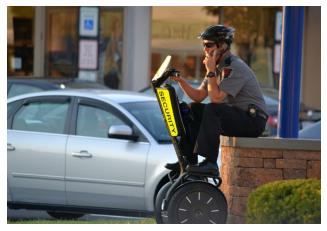

In [326]:
sample_img = mpl.image.imread(os.path.join(DATA_DIR,"val","person","000000383289.jpg"))

plt.figure()
plt.imshow(sample_img)
plt.axis("off")
plt.show()

And see its predictions

In [328]:
resized_img = tf.image.resize(sample_img, IMG_SIZE)/127.5 - 1
prediction = final_model.predict(resized_img[tf.newaxis, ...])

In [329]:
print("Scores:\n Car: {:.2f}, Negative: {:.2f}, Person: {:.2f}".format(*prediction.flatten().tolist()))

Scores:
 Car: 0.80, Negative: 0.00, Person: 1.00


Looks good, let's continue with adapting our model to accept the microcontroller data.

#### Dealing with the microcontroller data

Microcontrollers have limited memory, so the cameras that interface with them usually have more compressed color formats than a normal computer would. Indeed, the camera I will be using, OV7670, has a "YCbCr 4:2:2"(from which you could extract grayscale images) and RGB565 color modes. The standard RGB your computer uses for most of its work is 8 bits per color channel, so 24 bits are needed per pixel in RGB images. On the other hand, RGB565 uses 5 bits for red, 6 bits for green and another 5 bits for blue, for a total of 16 bits. This is quite convenient since one can store an image in `img_height*img_width /2` 32bit words.

Unfortunately, our model has an input shape of `(224,224,3)` for standard RGB images, so in a first instance we need to be able to convert between RGB888 and RGB555, so let's write a few functions so we can test it works

In [330]:
import tensorflow.bitwise as bw

def tf_rgb888_2_rgb565(img):
    # Expects a non normalized RGB image [0,255]
    img = tf.cast(img, tf.uint16)
    # Take most significant bits
    r = bw.right_shift(img[..., 0], 3) 
    g = bw.right_shift(img[..., 1], 2)
    b = bw.right_shift(img[..., 2], 3)

    # This is best seen as
    # img565 = (r<<11) | (g<<5) | (b<<0)
    # but in tensorflow ops looks like
    img565 = bw.bitwise_or( bw.bitwise_or(bw.left_shift(r, 11), 
            bw.left_shift(g, 5)), b)
    return img565

In [331]:
def tf_rgb565_2_rgb888(img):
    # Mask each color channel and rescale to the range [0,255]
    r = bw.right_shift(bw.bitwise_and(img, 0xF800), 11) * 255//0x1F
    g = bw.right_shift(bw.bitwise_and(img, 0x7E0), 5) * 255//0x3F
    b = bw.bitwise_and(img, 0x1F) * 255//0x1F
    
    img888 = tf.stack([r, g, b], axis=-1)
    
    return img888

Let's try converting the sample image to RGB565, and back to RGB888 to check everything works as planned

In [332]:
uc_img_size = (240, 320) # the resolution the OV7670 is configured for
sample_img = tf.Variable(sample_img, dtype=tf.uint16)

img_res = tf.image.resize(sample_img, uc_img_size)
img_565 = tf.expand_dims(tf_rgb888_2_rgb565(img_res), axis=0)
img_565_flat = tf.reshape(img_565, (1, -1))

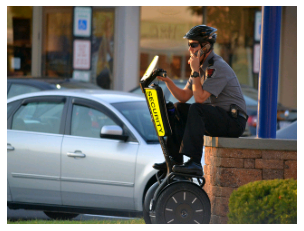

In [333]:
img_888 = tf_rgb565_2_rgb888(img_565)
plt.imshow(tf.squeeze(img_888))
plt.axis("off")
plt.show()

Good, the image looks exactly the same, although in reality we have lost some information in the process: There are more possible colors in 24 bits than in 16 bits, but that shouldn't be a problem.  

We could do all the preprocessing required in the C code, although it is simpler and in my opinion more elegant to make the model a standalone component. This way, we will be able to use the frame buffer that is directly captured by the camera as input to he network.

With that said, we need to perform the folowing preprocessing steps:

1. Reshape a flat `uint16` input of shape `(img_height*img_width)` to `(img_height, img_width)`
2. Convert color from RGB565 to RGB888. Output shape is `(img_height, img_width, 3)`
3. Normalize the pixels to the range `[-1, 1]`
4. Resize the image to `(input_height, input_width)`. In this case, `(224,224)`. Output shape is equal to the model input shape, `(224,224,3)`

> Note: As of October 2, 2020, ... (TODO)

In [801]:
def separate_bytes(c):
    batch_size = c.shape[0]
    a = tf.cast(bw.right_shift(c, 8), tf.uint8)
    b = tf.cast(c, tf.uint8)
    return tf.reshape(tf.stack([a, b], axis=-1), (batch_size, -1) )

In [802]:
sep = separate_bytes(img_565_flat)
sep

<tf.Tensor: shape=(1, 153600), dtype=uint8, numpy=array([[147, 136, 131, ..., 229,  49, 165]], dtype=uint8)>

In [778]:
def join_bytes(ab):
    batch_size = ab.shape[0]
    ab = tf.cast(tf.reshape(ab, (-1,2)), tf.uint16)
    a, b = tf.unstack(ab, axis=1)
    c = bw.bitwise_or(bw.left_shift(a, 8),b)
    c = tf.reshape(c, (batch_size, -1))
    return c

In [775]:
tf.math.reduce_all(join_bytes(sep) == img_565_flat)

<tf.Tensor: shape=(), dtype=bool, numpy=True>

To do so, let's create our own preprocessing layer:

In [868]:
import tensorflow.bitwise as bw

class PreprocessRGB565(keras.layers.Layer):
    """
    Transforms an RGB565 image of shape `img_size` to an RGB888 normalized [-1, 1] image
    of size `out_img_size`
    
    """
    def __init__(self, img_size, out_img_size):
        super(PreprocessRGB565, self).__init__()
        self.height, self.width = img_size
        self.out_img_size = out_img_size
        self.tst = tf.zeros((1,224,224,3))
    
    def build(self, batch_input_shape):
        super().build(batch_input_shape)
    
    def call(self, inputs):
        
        # Tflite doesn't support uint16, workaround is to merge two uint8 bytes
        # Please let me know if you know a better solution
        ab = tf.cast( tf.reshape(inputs, (-1,2)), tf.uint8) # each row has two uint8
        return self.tst + tf.cast(ab[0,0], tf.float32)
        a, b = tf.unstack(ab, axis=1) # separate columns
        c = bw.bitwise_or(bw.left_shift(a, 8),b) # merge columns into uint16
        reshaped_inputs = tf.reshape(c, (-1, self.height, self.width)) # (batch_size, height, width)
        # end of workaround

        # Reshape from (batch_size, height*width) to (batch_size, height, width)
        #img_565 = tf.reshape(inputs, (-1, self.height, self.width))
        img_565 = reshaped_inputs
        
        # We can convert the color and normalize to the range [-1,1] at the same time changing 
        # the scaling factor once the channel bits are masked. Channels red and blue range from
        # 0 to 2^5 -1 and channel green ranges from 0 to 2^6 -1.
        r = tf.cast(bw.right_shift(bw.bitwise_and(img_565, 0xF800), 11), tf.float32) /15.5 -1
        g = tf.cast(bw.right_shift(bw.bitwise_and(img_565, 0x7E0), 5), tf.float32) /31.5 -1
        b = tf.cast(bw.bitwise_and(img_565, 0x1F), tf.float32) /15.5 -1
        img_888 = tf.stack([r, g, b], axis=-1)
        
        # Resize the image
        res_img = tf.image.resize(img_888, self.out_img_size)
    
        return res_img
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "height": self.height, "width": self.width,
                "out_img_size": self.out_img_size}
    
    

We can now create our microcontroller model by adding an input layer and our preprocessing layer before the model:

In [869]:
capture_height, capture_width = uc_img_size

uc_model = keras.models.Sequential([
    keras.layers.InputLayer((capture_height*capture_width*2), dtype=tf.uint8), # It is important to specify dtype
    PreprocessRGB565(img_size=uc_img_size, out_img_size=IMG_SIZE),
    final_model
])

In [870]:
uc_model.save("./models/uc_model.h5")

If we now feed our RGB565 sample image to the network, we should get similar results:

In [871]:
img_sep = separate_bytes(img_565_flat)
img_sep.shape, img_sep.dtype

(TensorShape([1, 153600]), tf.uint8)

In [872]:
prediction = uc_model.predict(img_sep)
print("Scores:\n Car: {:.2f}, Negative: {:.2f}, Person: {:.2f}".format(*prediction.flatten().tolist()))

Scores:
 Car: 0.00, Negative: 1.00, Person: 0.00


As explained above, the reconstructed image is not exactly the same to the original due to the smaller RGB format, but as we can see the model still predicts the same classes(remember the threshold is 0.5). If you are surprised the model is so confident on the class scores, it is due to the nature of the macro double soft F1 loss(again, I advise you to read [this post](https://towardsdatascience.com/the-unknown-benefits-of-using-a-soft-f1-loss-in-classification-systems-753902c0105d) and the paper linked there).

Let's double check and evaluate this model on all validation examples

In [797]:
def to_uc_format(img):
    # Transform each image to the microcontroller raw capture format
    non_norm_img = (img+1)*127.5
    resized_img = tf.image.resize(non_norm_img, uc_img_size)
    img_565 = tf_rgb888_2_rgb565(resized_img)
    img_565_flat = tf.reshape(img_565, (-1, 1))
    sep_img = separate_bytes(img_565_flat)
    return sep_img

In [798]:
uc_val_ds = val_ds.unbatch().map(lambda x, y: (to_uc_format(x), y)).batch(32)

In [799]:
LOSS = MacroDoubleSoftF1()
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name="bin_accuracy"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
    tfa.metrics.F1Score(len(class_names), average="macro", name="MacroF1"),
]

uc_model.compile(optimizer="SGD", loss=LOSS, metrics=METRICS) #arbitrary optimizer since we are not going to train it

In [800]:
metrics = uc_model.evaluate(uc_val_ds, verbose=0)
print("Loss: {:.2f}, Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, MacroF1: {:.2f}".format(*metrics))

Loss: 0.11, Accuracy: 0.91, Precision: 0.88, Recall: 0.87, MacroF1: 0.87


The performance has slightly decreased, but nothing to worry about; Seems to work quite well. We are ready to convert this model to a compressed tflite format so we can use it in our microcontroller.

### Compress the model

In [873]:
def compress_and_save(model, name):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    #converter.target_spec.supported_types = [tf.float16]
    tflite_model = converter.convert()
    
    with open(name, 'wb') as f:
        f.write(tflite_model)
        
    return tflite_model

In [821]:
lite_model = compress_and_save(uc_model, "uc_model.tflite")

INFO:tensorflow:Assets written to: C:\Users\Kique\AppData\Local\Temp\tmpdlhhb9ph\assets


INFO:tensorflow:Assets written to: C:\Users\Kique\AppData\Local\Temp\tmpdlhhb9ph\assets


# References

- [Coco dataset](https://cocodataset.org/#home)
- [CocoAPI for Python3 and Windows](https://github.com/philferriere/cocoapi#egg=pycocotools^&subdirectory=PythonAPI)
- [Visual wake word dataset](https://arxiv.org/abs/1906.05721)
- [Python docs](https://docs.python.org/3/)
- A lot of [stackoverflow](https://stackoverflow.com/)
- [The Unknown Benefits of using a Soft-F1 Loss in Classification Systems](https://towardsdatascience.com/the-unknown-benefits-of-using-a-soft-f1-loss-in-classification-systems-753902c0105d)
- [8 Tactics to Combat Imbalanced Classes in Your Machine Learning Dataset](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/)
- [Classification on imbalanced data](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data)
- [Handling Data Imbalance in Multi-label Classification (MLSMOTE)](https://medium.com/thecyphy/handling-data-imbalance-in-multi-label-classification-mlsmote-531155416b87)
- [Tensorflow guides](https://www.tensorflow.org/guide) and [tensorflow tutorials](https://www.tensorflow.org/tutorials)
- [EfficentNet](https://arxiv.org/abs/1905.11946)
- [NASNet](https://arxiv.org/abs/1707.07012)
- [The Unknown Benefits of using a Soft-F1 Loss in Classification Systems](https://towardsdatascience.com/the-unknown-benefits-of-using-a-soft-f1-loss-in-classification-systems-753902c0105d)
- [Cars dataset](https://ai.stanford.edu/~jkrause/cars/car_dataset.html)
